In [1]:
'''
author: EdgardoCS @FSU Jena
date: 18.06.2025
'''

# install openpyxl

import bambi as bmb
import arviz as az
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.genmod as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

In [2]:
input_data = 'output/data_sorted.xlsx'
columns = ['Id', 'Age', 'Rating', 'Gender', 'Segment', 'Location', 'Type']

data = pd.read_excel(input_data, usecols=columns)

# focus on Female and Male for now
data = (data[data['Gender'].isin(['Female', 'Male'])])

In [3]:
data["Gender"].value_counts()

Gender
Female    17415
Male       9500
Name: count, dtype: int64

In [4]:
data["Segment"].value_counts()

Segment
Armpits    6549
Pelvis     4499
Feet       4408
Neck       2798
Hands      2404
Mouth      1897
Hair       1891
Chest      1890
Legs        579
Name: count, dtype: int64

In [5]:
data["Location"].value_counts()

Location
Front    16864
Back     10051
Name: count, dtype: int64

In [6]:
data["Type"].value_counts()

Type
Other    14714
Self     12201
Name: count, dtype: int64

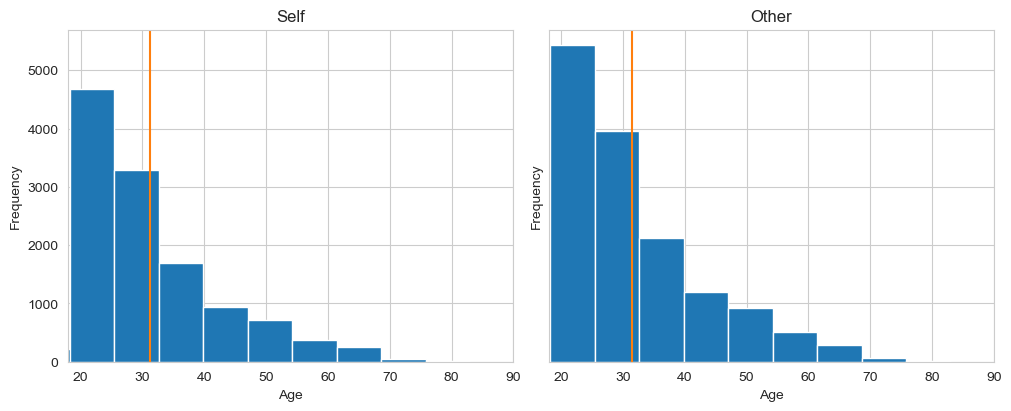

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, constrained_layout=True)
key = dict(zip(data["Type"].unique(), range(3)))
for label, df in data.groupby("Type"):
    ax[key[label]].hist(df["Age"])
    ax[key[label]].set_xlim([18, 90])
    ax[key[label]].set_xlabel("Age")
    ax[key[label]].set_ylabel("Frequency")
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df["Age"].mean(), color="C1")

In [8]:
# Define all factor levels
c1 = ['Self', 'Other']
c2 = ['Front', 'Back']
c3 = ['Armpits', 'Chest', 'Feet', 'Hair', 'Hands', 'Legs', 'Mouth', 'Neck', 'Pelvis']
# c4 = ['Male', 'Female']

In [9]:
# Build full grid for each subject × all combinations of the 3 factors
all_combos = pd.DataFrame([
    (i, g, t, l)
    for i in data['Id'].unique()
    for g, t, l in itertools.product(c1, c2, c3)
], columns=['Id', 'Type', 'Location', 'Segment'])

# Add indicator of whether that combination was rated
data['Marked'] = (data['Rating'] > 0).astype(int)

# Merge data with all possible combinations
merged = all_combos.merge(
    data[['Id', 'Type', 'Location', 'Segment', 'Marked']],
    on=['Id', 'Type', 'Location', 'Segment'],
    how='left'
)

In [10]:
# Add Age and Gender, avoid duplicate data
merged = merged.merge(
    data[['Id', 'Type', 'Location', 'Segment', 'Age', 'Gender']],
    on=['Id', 'Type', 'Location', 'Segment'],
    how='left'
)
# Fill for all
merged['Age'] = merged.groupby('Id')['Age'].transform(lambda x: x.ffill().bfill())
merged['Gender'] = merged.groupby('Id')['Gender'].transform(lambda x: x.ffill().bfill())

# Fill missing with 0 = not marked
merged['Marked'] = merged['Marked'].fillna(0).astype(int)

In [11]:
female_df = merged[merged['Gender'] == 'Female'].copy()
male_df = merged[merged['Gender'] == 'Male'].copy()

In [12]:
female_df["Marked"].value_counts()

Marked
0    37449
1    17415
Name: count, dtype: int64

In [13]:
male_df["Marked"].value_counts()

Marked
0    22360
1     9500
Name: count, dtype: int64

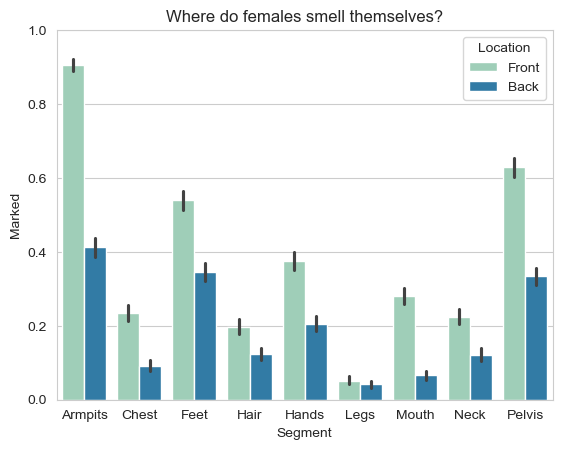

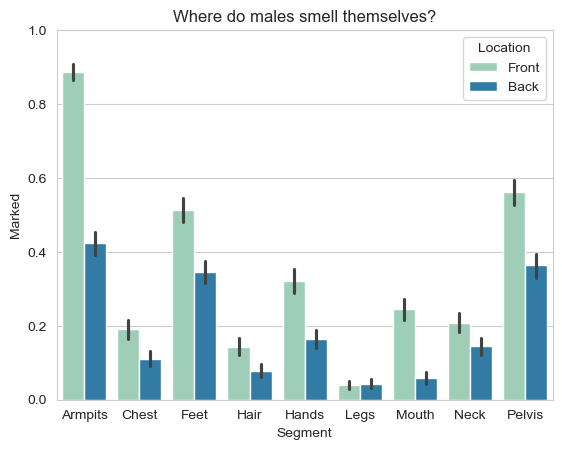

In [19]:
data = female_df[female_df['Type'] == 'Self']
sns.barplot(
    data=data,
    hue="Location",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 1)
plt.title('Where do females smell themselves?')
plt.show()

data = male_df[male_df['Type'] == 'Self']
sns.barplot(
    data=data,
    hue="Location",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 1)
plt.title('Where do males smell themselves?')
plt.show()

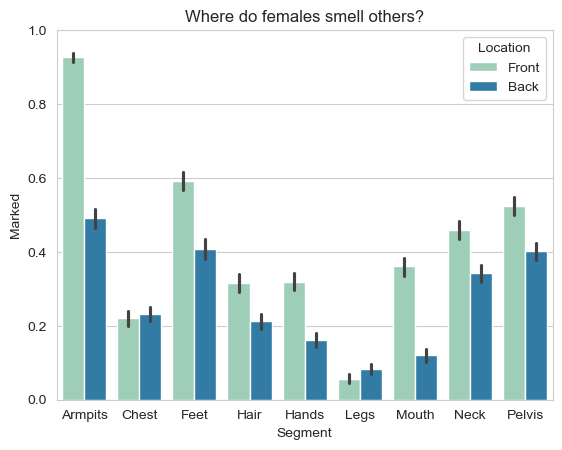

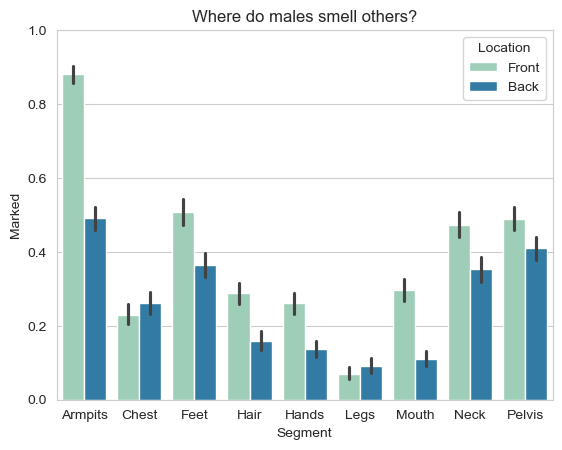

In [20]:
data = female_df[female_df['Type'] == 'Other']
sns.barplot(
    data=data,
    hue="Location",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 1)
plt.title('Where do females smell others?')
plt.show()

data = male_df[male_df['Type'] == 'Other']
sns.barplot(
    data=data,
    hue="Location",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 1)
plt.title('Where do males smell others?')
plt.show()

In [21]:
# types = ['Self', 'Other']
# colors = ['#41b6c4', '#225ea8']
#
# grouped = female_df.groupby(['Segment', 'Location', 'Type'])['Marked']
# estimates = grouped.mean().reset_index()
# estimates = estimates.rename(columns={'Marked': 'Mean_Marked'})
#
# for i, t in enumerate(types):
#     pivot_df = estimates[estimates['Type'] == t].pivot(
#         index='Location',
#         columns='Segment',
#         values='Mean_Marked'
#     )
#     categories = list(pivot_df.columns)
#     N = len(categories)
#
#     angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
#     angles += angles[:1]
#
#     fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
#
#     for idx, row in pivot_df.iterrows():
#         values = row.tolist()
#         values += values[:1]
#         if idx == "Front":
#             ax.plot(angles, values, label=idx, color=colors[0])
#             ax.fill(angles, values, alpha=0.1, color=colors[0])
#         elif idx == "Back":
#             ax.plot(angles, values, label=idx, color=colors[1])
#             ax.fill(angles, values, alpha=0.1, color=colors[1])
#
#     # ticks = [0.15, 0.30, 0.45]
#
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(categories)
#     # ax.set_yticks(ticks)
#     ax.set_title(f'Females Body Odor Ratings ({t})')
#     ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
#     plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
#     plt.savefig('output/radar-female-' + t + '.png', dpi=350, bbox_inches='tight')
#     plt.show()

In [22]:
# grouped = male_df.groupby(['Segment', 'Location', 'Type'])['Marked']
# estimates = grouped.mean().reset_index()
# estimates = estimates.rename(columns={'Marked': 'Mean_Marked'})
#
# for i, t in enumerate(types):
#     pivot_df = estimates[estimates['Type'] == t].pivot(
#         index='Location',
#         columns='Segment',
#         values='Mean_Marked'
#     )
#     categories = list(pivot_df.columns)
#     N = len(categories)
#
#     angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
#     angles += angles[:1]
#
#     fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
#
#     for idx, row in pivot_df.iterrows():
#         values = row.tolist()
#         values += values[:1]
#         if idx == "Front":
#             ax.plot(angles, values, label=idx, color=colors[0])
#             ax.fill(angles, values, alpha=0.1, color=colors[0])
#         elif idx == "Back":
#             ax.plot(angles, values, label=idx, color=colors[1])
#             ax.fill(angles, values, alpha=0.1, color=colors[1])
#
#     # ticks = [0.15, 0.30, 0.45]
#
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(categories)
#     # ax.set_yticks(ticks)
#     ax.set_title(f'Males Body Odor Ratings ({t})')
#     ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
#     plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
#     plt.savefig('output/radar-male-' + t + '.png', dpi=350, bbox_inches='tight')
#     plt.show()

In [23]:
# Logistic mixed-effects model
model = smf.glm(
    "Marked ~ Segment * Gender * Location * Type",
    data=merged,
    family=sm.families.Binomial()
)
model_fit = model.fit()
print(model_fit.summary())

# Reference: Female, Others, armpit
# Intercept -0,0315, p = 0.539 (ns)

# Location (front)   2,585, p < 0.001 (***)
# Type (Self)       -0,321, p < 0.001 (***)
# Gender (Male)     -0,002, p = 0,977 (ns)
# β, p
# # Compared to the highest rated Segment, armpit, the rest of the segments were rated significantly lower.
# Segment[T.chest]  -1,167,    p < 0.001 (***)
# Segment[T.feet]   -0,337,    p < 0.001 (***)
# Segment[T.hair]   -1,067,    p < 0.001 (***)
# Segment[T.hand]   -1,621,    p < 0.001 (***)
# Segment[T.legs]   -2,366,    p < 0.001 (***)
# Segment[T.mouth]  -1,954,    p < 0.001 (***)
# Segment[T.neck]   -0,617,    p < 0.001 (***)
# Segment[T.pelvis] -0,362,    p < 0.001 (***)

# # All segments were rated significantly higher in front
# Segment[T.Chest]:Location[T.Front]    -2.6490   p < 0.001 (***)
# Segment[T.Feet]:Location[T.Front]     -1.8446   p < 0.001 (***)
# Segment[T.Hair]:Location[T.Front]     -2.0499   p < 0.001 (***)
# Segment[T.Hands]:Location[T.Front]    -1.6854   p < 0.001 (***)
# Segment[T.Legs]:Location[T.Front]     -2.9796   p < 0.001 (***)
# Segment[T.Mouth]:Location[T.Front]    -1.1684   p < 0.001 (***)
# Segment[T.Neck]:Location[T.Front]     -2.0965   p < 0.001 (***)
# Segment[T.Pelvis]:Location[T.Front]   -2.0919   p < 0.001 (***)

# # Gender doesnt appear to have a significant effect
# Segment[T.Chest]:Gender[T.Male]      0.1609    p = 0.213 (ns)
# Segment[T.Feet]:Gender[T.Male]      -0.1874    p = 0.123 (ns)
# Segment[T.Hair]:Gender[T.Male]      -0.3431    p = 0.014 (*)
# Segment[T.Hands]:Gender[T.Male]     -0.1783    p = 0.224 (ns)
# Segment[T.Legs]:Gender[T.Male]       0.1187    p = 0.487 (ns)
# Segment[T.Mouth]:Gender[T.Male]     -0.0839    p = 0.593 (ns)
# Segment[T.Neck]:Gender[T.Male]       0.0486    p = 0.691 (ns)
# Segment[T.Pelvis]:Gender[T.Male]     0.0326    p = 0.787 (ns)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Marked   No. Observations:                86724
Model:                            GLM   Df Residuals:                    86652
Model Family:                Binomial   Df Model:                           71
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44180.
Date:                Tue, 24 Jun 2025   Deviance:                       88359.
Time:                        09:50:35   Pearson chi2:                 8.67e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1974
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [24]:
check = pd.crosstab([merged['Segment'], merged['Location']], merged['Marked'])
print(check)

Marked               0     1
Segment Location            
Armpits Back      2629  2189
        Front      458  4360
Chest   Back      3996   822
        Front     3750  1068
Feet    Back      3040  1778
        Front     2188  2630
Hair    Back      4092   726
        Front     3653  1165
Hands   Back      3991   827
        Front     3241  1577
Legs    Back      4505   313
        Front     4552   266
Mouth   Back      4381   437
        Front     3358  1460
Neck    Back      3667  1151
        Front     3171  1647
Pelvis  Back      3010  1808
        Front     2127  2691


In [31]:
# 1. Is there any difference between Female and Male when smelling Others?
target1 = (merged[
               (merged['Type'] == 'Other') &
               (merged['Gender'].isin(['Female', 'Male']))]
           .copy())
# same model, only for type others
model1 = smf.mixedlm(
    "Marked ~ Segment * Location * Gender",
    target1,
    groups=target1["Id"]
)
model1_fit = model.fit()

print(model1_fit.summary())

# Location (front)    0.436, p < 0.001 (***)
# Gender (Male)      -0.001, p = 0.974 (ns)
# β, p
# Compared to the highest rated Segment, Armpit, the rest of the segments were rated significantly lower when smelling others.
# Segment[T.Chest]                                   -0.260   p < 0.001 (***)
# Segment[T.Feet]                                    -0.083   p < 0.001 (***)
# Segment[T.Hair]                                    -0.280   p < 0.001 (***)
# Segment[T.Hands]                                   -0.331   p < 0.001 (***)
# Segment[T.Legs]                                    -0.409   p < 0.001 (***)
# Segment[T.Mouth]                                   -0.371   p < 0.001 (***)
# Segment[T.Neck]                                    -0.149   p < 0.001 (***)
# Segment[T.Pelvis]                                  -0.089   p < 0.001 (***)

# All segments were rated significantly higher in front.
# Segment[T.Chest]:Location[T.Front]                 -0.447  p < 0.001 (***)
# Segment[T.Feet]:Location[T.Front]                  -0.253  p < 0.001 (***)
# Segment[T.Hair]:Location[T.Front]                  -0.333  p < 0.001 (***)
# Segment[T.Hands]:Location[T.Front]                 -0.276  p < 0.001 (***)
# Segment[T.Legs]:Location[T.Front]                  -0.461  p < 0.001 (***)
# Segment[T.Mouth]:Location[T.Front]                 -0.195  p < 0.001 (***)
# Segment[T.Neck]:Location[T.Front]                  -0.319  p < 0.001 (***)
# Segment[T.Pelvis]:Location[T.Front]                -0.314  p < 0.001 (***)

# Gender appears to have no significance overall
# Segment[T.Chest]:Gender[T.Male]       0.030    p = 0.212 (ns)
# Segment[T.Feet]:Gender[T.Male]       -0.044    p = 0.065 (ns)
# Segment[T.Hair]:Gender[T.Male        -0.052    p = 0.032 (*)
# Segment[T.Hands]:Gender[T.Male]      -0.022    p = 0.353 (ns)
# Segment[T.Legs]:Gender[T.Male]        0.010    p = 0.679 (ns)
# Segment[T.Mouth]:Gender[T.Male]      -0.008    p = 0.731 (ns)
# Segment[T.Neck]:Gender[T.Male]        0.011    p = 0.644 (ns)
# Segment[T.Pelvis]:Gender[T.Male]      0.008    p = 0.743 (ns)
# Location[T.Front]:Gender[T.Male]     -0.046    p = 0.056 (ns)

                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             Marked     
No. Observations:              43362               Method:                         REML       
No. Groups:                    2409                Scale:                          0.1614     
Min. group size:               18                  Log-Likelihood:                 -23606.1771
Max. group size:               18                  Converged:                      Yes        
Mean group size:               18.0                                                           
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           0.492    0.011  44.808 0.00

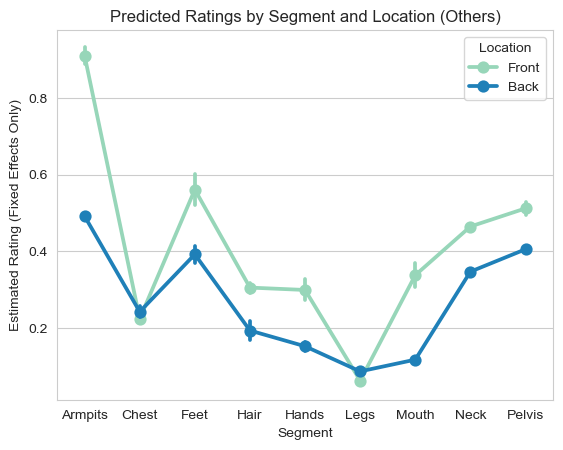

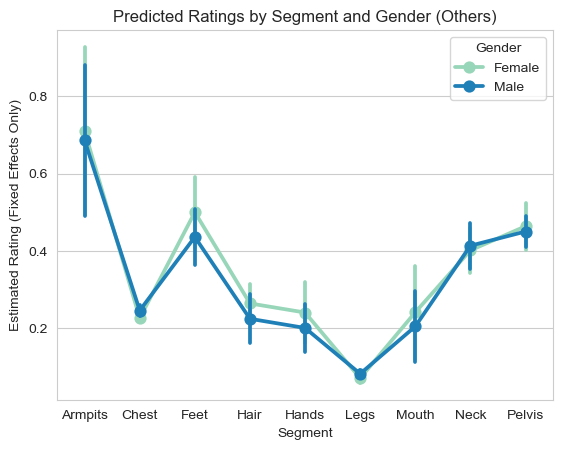

In [32]:
predict_df = target1.copy()
predict_df["Id"] = 0  # Dummy ID for prediction

# Predict with fixed effects only (excluding random effects)
predictions = model1_fit.predict(predict_df)

# Attach predictions
predict_df["Predicted"] = predictions

sns.pointplot(
    data=predict_df,
    x="Segment",
    hue="Location",
    y="Predicted",
    errorbar="sd",
    palette='YlGnBu'
)
plt.title("Predicted Ratings by Segment and Location (Others)")
plt.ylabel("Estimated Rating (Fixed Effects Only)")
plt.savefig('output/stats/pointplot-others-location.png', bbox_inches='tight', dpi=300)
plt.show()

sns.pointplot(
    data=predict_df,
    x="Segment",
    hue="Gender",
    y="Predicted",
    errorbar="sd",
    palette='YlGnBu'
)
plt.title("Predicted Ratings by Segment and Gender (Others)")
plt.ylabel("Estimated Rating (Fixed Effects Only)")
plt.savefig('output/stats/pointplot-others-gender.png', bbox_inches='tight', dpi=300)
plt.show()

In [50]:
# 2. Is there any difference between Female and Male when smelling Themselves?
target2 = (merged[
               (merged['Type'] == 'Self') &
               (merged['Gender'].isin(['Female', 'Male']))]
           .copy())
# same model, only for type others
model2 = smf.mixedlm(
    "Marked ~ Segment * Location * Gender",
    target2,
    groups=target2["Id"]
)
model2_fit = model2.fit()

print(model2_fit.summary())

# Location (front)   0.493, p < 0.001 (***)
# Gender (Male)      0.011, p = 0.508 (ns)
# β, p
# Compared to the highest rated Segment, Armpit, the rest of the segments were rated significantly lower when smelling themselves.
# Segment[T.chest]  -0.320,    p < 0.001 (***)
# Segment[T.feet]   -0.067,    p < 0.001 (***)
# Segment[T.hair]   -0.288,    p < 0.001 (***)
# Segment[T.hand]   -0.207,    p < 0.001 (***)
# Segment[T.legs]   -0.370,    p < 0.001 (***)
# Segment[T.mouth]  -0.346,    p < 0.001 (***)
# Segment[T.neck]   -0.291,    p < 0.001 (***)
# Segment[T.pelvis] -0.079,    p < 0.001 (***)

# All segments were rated significantly higher in front.
# Segment[T.chest]:Location[T.Front]   -0.350,   p < 0.001 (***)
# Segment[T.feet]:Location[T.Front]    -0.298,   p < 0.001 (***)
# Segment[T.hair]:Location[T.Front]    -0.419,   p < 0.001 (***)
# Segment[T.hand]:Location[T.Front]    -0.324,   p < 0.001 (***)
# Segment[T.legs]:Location[T.Front]    -0.483,   p < 0.001 (***)
# Segment[T.mouth]:Location[T.Front]   -0.278,   p < 0.001 (***)
# Segment[T.neck]:Location[T.Front]    -0.390,   p < 0.001 (***)
# Segment[T.pelvis]:Location[T.Front]  -0.197,   p < 0.001 (***)

# Gender appears to have no significance overall, although hair was rated significantly higher for females
# Segment[T.Chest]:Gender[T.Male]                     0.006   0.782
# Segment[T.Feet]:Gender[T.Male]                     -0.011   0.617
# Segment[T.Hair]:Gender[T.Male]                     -0.057   0.010 (**)
# Segment[T.Hands]:Gender[T.Male]                    -0.052   0.018
# Segment[T.Legs]:Gender[T.Male]                     -0.010   0.664
# Segment[T.Mouth]:Gender[T.Male]                    -0.019   0.384
# Segment[T.Neck]:Gender[T.Male]                      0.013   0.564
# Segment[T.Pelvis]:Gender[T.Male]                    0.019   0.392
# Location[T.Front]:Gender[T.Male]                   -0.028   0.198

                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             Marked     
No. Observations:              43362               Method:                         REML       
No. Groups:                    2409                Scale:                          0.1360     
Min. group size:               18                  Log-Likelihood:                 -19886.2913
Max. group size:               18                  Converged:                      Yes        
Mean group size:               18.0                                                           
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           0.413    0.010  40.960 0.00

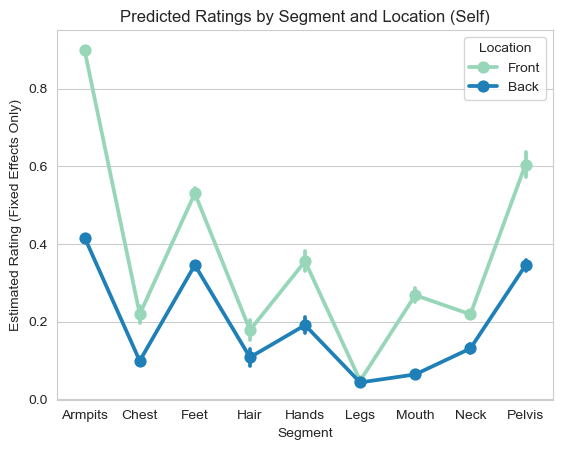

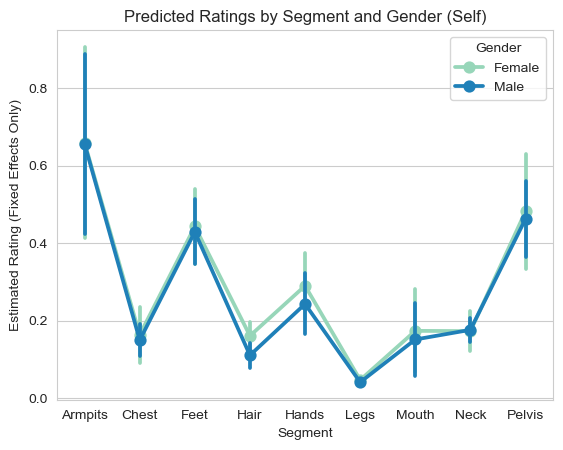

In [51]:
predict_df = target2.copy()
predict_df["Id"] = 0  # Dummy ID for prediction

# Predict with fixed effects only (excluding random effects)
predictions = model2_fit.predict(predict_df)

# Attach predictions
predict_df["Predicted"] = predictions

sns.pointplot(
    data=predict_df,
    x="Segment",
    hue="Location",
    y="Predicted",
    errorbar="sd",
    palette='YlGnBu'
)
plt.title("Predicted Ratings by Segment and Location (Self)")
plt.ylabel("Estimated Rating (Fixed Effects Only)")
plt.savefig('output/stats/pointplot-others-location.png', bbox_inches='tight', dpi=300)
plt.show()

sns.pointplot(
    data=predict_df,
    x="Segment",
    hue="Gender",
    y="Predicted",
    errorbar="sd",
    palette='YlGnBu'
)
plt.title("Predicted Ratings by Segment and Gender (Self)")
plt.ylabel("Estimated Rating (Fixed Effects Only)")
plt.savefig('output/stats/pointplot-others-gender.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# 3. is there any difference when Males smell themselves vs when they smell Others?
target3 = (merged[
               (merged['Gender'] == 'Male')
           ]
           .copy())
# same model, only for type others
model3 = smf.mixedlm(
    "Marked ~ Segment * Location * Type",
    target3,
    groups=target3["Id"]
)
model3_fit = model3.fit()

print(model3_fit.summary())

# Segment[T.Chest]:Type[T.Self]                    -0.084    p = 0.001 (***)
# Segment[T.Feet]:Type[T.Self]                      0.050    p = 0.055
# Segment[T.Hair]:Type[T.Self]                     -0.014    p = 0.601
# Segment[T.Hands]:Type[T.Self]                     0.095    p < 0.001 (***)
# Segment[T.Legs]:Type[T.Self]                      0.019    p = 0.459
# Segment[T.Mouth]:Type[T.Self]                     0.015    p = 0.571
# Segment[T.Neck]:Type[T.Self]                     -0.140    p < 0.001 (***)
# Segment[T.Pelvis]:Type[T.Self]                    0.021    p = 0.408
# Location[T.Front]:Type[T.Self]                    0.075    p = 0.004 (**)

# Segment[T.Chest]:Location[T.Front]:Type[T.Self]   0.037    p = 0.309
# Segment[T.Feet]:Location[T.Front]:Type[T.Self]   -0.052    p = 0.156
# Segment[T.Hair]:Location[T.Front]:Type[T.Self]   -0.138    p < 0.001 (***)
# Segment[T.Hands]:Location[T.Front]:Type[T.Self]  -0.043    p = 0.242
# Segment[T.Legs]:Location[T.Front]:Type[T.Self]   -0.058    p = 0.116
# Segment[T.Mouth]:Location[T.Front]:Type[T.Self]  -0.073    p = 0.045 (*)
# Segment[T.Neck]:Location[T.Front]:Type[T.Self]   -0.132    p < 0.001 (***)
# Segment[T.Pelvis]:Location[T.Front]:Type[T.Self]  0.043    p = 0.242

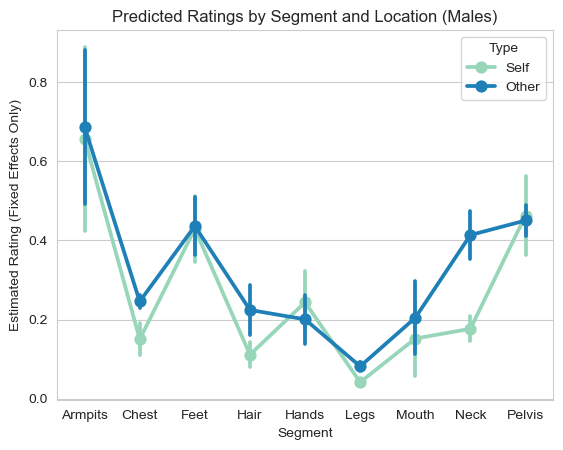

In [81]:
predict_df = target3.copy()
predict_df["Id"] = 0  # Dummy ID for prediction

# Predict with fixed effects only (excluding random effects)
predictions = model3_fit.predict(predict_df)

# Attach predictions
predict_df["Predicted"] = predictions

sns.pointplot(
    data=predict_df,
    x="Segment",
    hue="Type",
    y="Predicted",
    errorbar="sd",
    palette='YlGnBu'
)
plt.title("Predicted Ratings by Segment and Location (Males)")
plt.ylabel("Estimated Rating (Fixed Effects Only)")
plt.savefig('output/stats/pointplot-others-location.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# 4. is there any difference when Females smell themselves vs when they smell Others?
target4 = (merged[
               (merged['Gender'] == 'Female')
           ]
           .copy())
model4 = smf.mixedlm(
    "Marked ~ Segment * Location * Type",
    target4,
    groups=target4["Id"]
)
model4_fit = model4.fit()

print(model4_fit.summary())

# Segment[T.Chest]:Type[T.Self]                    -0.060    p = 0.003 (**)
# Segment[T.Feet]:Type[T.Self]                      0.016    p = 0.412
# Segment[T.Hair]:Type[T.Self]                     -0.009    p = 0.669
# Segment[T.Hands]:Type[T.Self]                     0.125    p < 0.001 (**)
# Segment[T.Legs]:Type[T.Self]                      0.039    p = 0.053
# Segment[T.Mouth]:Type[T.Self]                     0.026    p = 0.200
# Segment[T.Neck]:Type[T.Self]                     -0.142    p < 0.001 (***)
# Segment[T.Pelvis]:Type[T.Self]                    0.010    p = 0.599
# Location[T.Front]:Type[T.Self]                    0.057    p = 0.004 (**)
#
# Segment[T.Chest]:Location[T.Front]:Type[T.Self]   0.097    p = 0.001 (**)
# Segment[T.Feet]:Location[T.Front]:Type[T.Self]   -0.045    p = 0.109
# Segment[T.Hair]:Location[T.Front]:Type[T.Self]   -0.087    p = 0.002 (**)
# Segment[T.Hands]:Location[T.Front]:Type[T.Self]  -0.048    p = 0.090
# Segment[T.Legs]:Location[T.Front]:Type[T.Self]   -0.022    p = 0.443
# Segment[T.Mouth]:Location[T.Front]:Type[T.Self]  -0.083    p = 0.003 (**)
# Segment[T.Neck]:Location[T.Front]:Type[T.Self]   -0.071    p = 0.012 (*)
# Segment[T.Pelvis]:Location[T.Front]:Type[T.Self]  0.117    p < 0.001 (***)

In [ ]:
# 5. Comparing the body as whole, is there any difference between Female and Males when smelling themselves in front and back, and what about when smelling Others?
target5 = (merged[
               (merged['Type'].isin(['Self', 'Other'])) &
               (merged['Gender'].isin(['Female', 'Male']))]
           .copy())
model5 = smf.mixedlm(
    "Marked ~ Gender * Location * Type",
    target5,
    groups=target5["Id"]
)
model5_fit = model5.fit()

print(model5_fit.summary())

# Effect of location (Front - Back)
# β = 0.147, p < 0.0001 (***)

# Effect of Gender (Female - Male)
# β = -0.008, p = 0.328 (ns)

# Effect of Location and type
# Location[T.Front]:Type[T.Self]  β = 0.041, p < 0.0001 (***)

In [78]:
# 6. Where do Females prefer to smell themselves (Front)
new_merge = merged[merged['Segment']!= "Armpits"]

target6 = new_merge[
    (new_merge['Location'] == 'Front') &
    (new_merge['Gender'] == 'Male') &
    (new_merge['Type'] == 'Self')
    ].copy()

model6 = smf.glm('Marked ~ Segment', data=new_merge, family=sm.families.Binomial()).fit()
print(model6.summary())

target6 = new_merge[
    (new_merge['Location'] == 'Front') &
    (new_merge['Gender'] == 'Male') &
    (new_merge['Type'] == 'Other')
    ].copy()

model6 = smf.glm('Marked ~ Segment', data=new_merge, family=sm.families.Binomial()).fit()
print(model6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Marked   No. Observations:                77088
Model:                            GLM   Df Residuals:                    77080
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -41031.
Date:                Tue, 24 Jun 2025   Deviance:                       82062.
Time:                        11:50:30   Pearson chi2:                 7.71e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08631
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.4106      0.02

In [52]:
# # 3. What are the odds for females to smell others?
# target3 = (merged[
#               (merged['Gender']== 'Female')]
#           .copy())

In [60]:
# # y = 1 if the person marks Front
# # y = 0 if the person marks back
# #
# # x1 = 1 if segment is armpit, 0 otherwise
# # x2 = 1 if segment is chest, 0 otherwise
# # xn = 1 if segment is n, 0 otherwise
#
# model3 = bmb.Model("Marked['1'] ~ Location + Location:Type", data=target3, family="bernoulli")
# model3_fit = model3.fit(draws=2000, target_accept=0.85, idata_kwargs={"log_likelihood": True})

Modeling the probability that Marked==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Location, Location:Type]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 89 seconds.


In [61]:
# az.summary(model3_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.980,0.019,-1.015,-0.944,0.0,0.0,7018.0,6047.0,1.0
Location[Front],0.657,0.026,0.606,0.702,0.0,0.0,6497.0,5948.0,1.0
"Location:Type[Back, Self]",-0.443,0.029,-0.499,-0.391,0.0,0.0,6550.0,5301.0,1.0
"Location:Type[Front, Self]",-0.155,0.025,-0.203,-0.109,0.0,0.0,6739.0,5680.0,1.0


In [63]:
# locations = ["Front, Self", "Back, Self"]
# dem, ind = [model3_fit.posterior["Location:Type"].sel({"Location:Type_dim":location}) for location in locations]

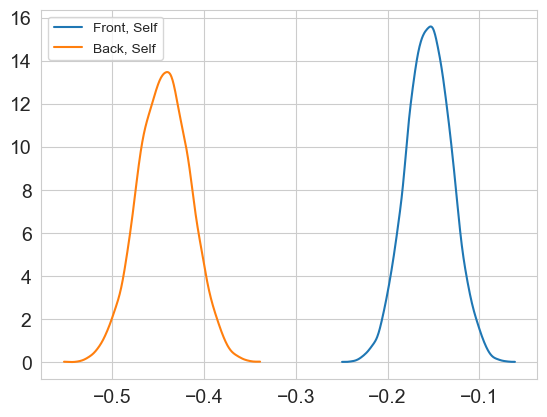

In [64]:
# _, ax = plt.subplots()
# for idx, x in enumerate([dem, ind]):
#     az.plot_dist(x, label=x["Location:Type_dim"].item(), plot_kwargs={"color": f"C{idx}"}, ax=ax)
# ax.legend(loc="upper left");

0.0

0.0

0.0

   Segment  Interaction  Log odds  Odds Ratio (exp(Δ))          %
0  Armpits        0.000    -1.518             0.219150 -78.085025
1    Chest        0.244    -0.480             0.618783 -38.121661
2     Feet       -0.089    -0.813             0.443525 -55.647451
3     Hair       -0.179    -0.903             0.405352 -59.464822
4    Hands       -0.031    -0.755             0.470011 -52.998939
5     Legs        0.263    -0.461             0.630653 -36.934732
6    Mouth        0.056    -0.668             0.512733 -48.726698
7     Neck        0.107    -0.617             0.539561 -46.043931
8   Pelvis        0.069    -0.655             0.519442 -48.055794


C:\Users\silva\AppData\Local\Temp\ipykernel_21884\2869165086.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gender_others = pd.concat([gender_others, pd.DataFrame([new_row])], ignore_index=True)


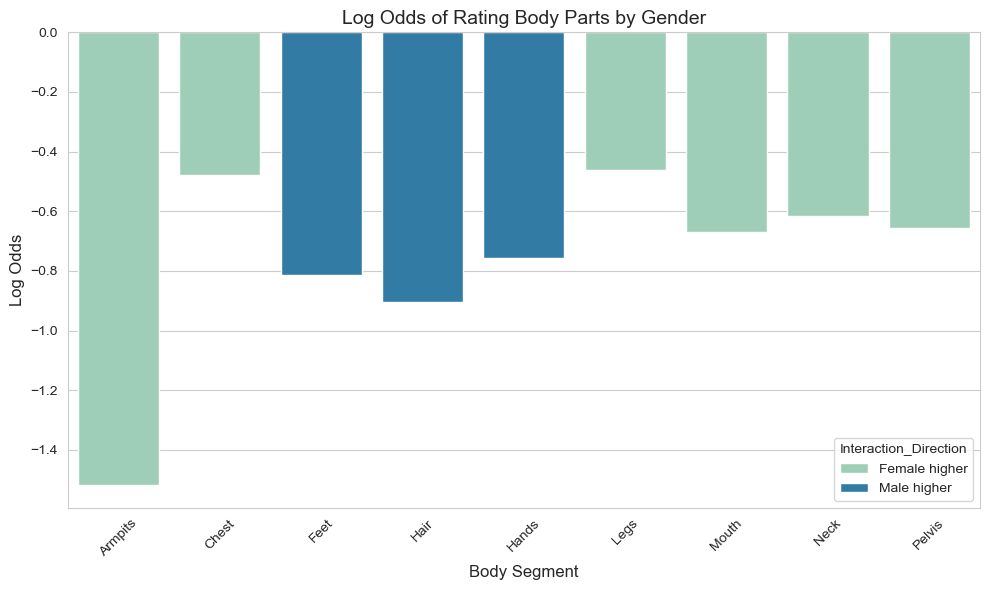

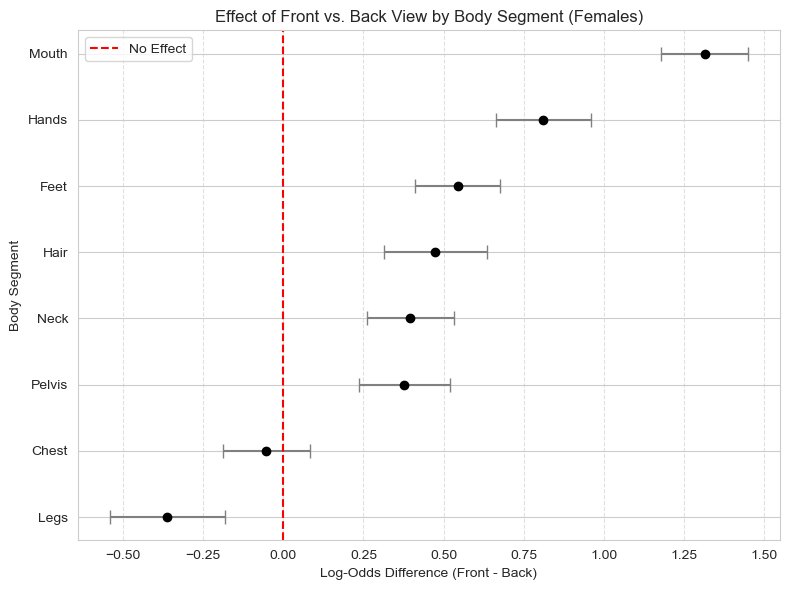